# Initialization

In [1]:
import torch
import tools
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tqdm
import copy
device = torch.device("cpu")

2023-05-17 21:03:59.795788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 21:03:59.959048: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-17 21:04:00.528163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ashishgaurav13/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-05-17 21:04:00.528240: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

pygame 2.1.2 (SDL 2.0.16, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def seed_fn(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
seed_fn(1)

# Create environments

In [4]:
gridworld_dim = 7
n_actions = 8

def create_env():
    r = np.zeros((7, 7)); r[6, 6] = 1.
    t = [(6, 6)]
    u = [(ui, uj) for ui in [2,3,4] for uj in [2,3,4]]
    s = [(ui, uj) for ui in [0,1] for uj in [0,1]]
    s += [(ui, uj) for ui in [2,3,4,5,6] for uj in [0,1]]
    s += [(ui, uj) for ui in [0,1] for uj in [2,3,4,5,6]]
    env = tools.environments.GridworldEnvironment(\
              start_states=s,
              t=t,
              r=r,
              unsafe_states=u,
              stay_action=False, # no action to "stay in current cell"
    )
    env = tools.environments.TimeLimit(env, 200)
    env = tools.environments.FollowGymAPI(env)
    return env

env, test_env = create_env(), create_env()

# Ground truth constraint function

In [5]:
def true_constraint_function(sa):
    s, a = sa
    x, y = s[0], s[1]
    u = [(ui, uj) for ui in [2,3,4] for uj in [2,3,4]]
    if (x, y) in u:
        return 1
    else:
        return 0

Visualize the ground truth constraint function:

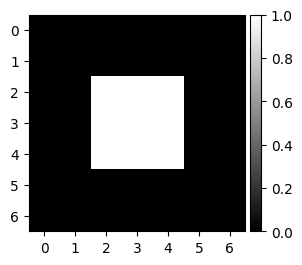

In [6]:
def gridworld_imshow(m, fig, ax):
    m = np.array(m).squeeze()
    assert(len(m.shape) == 2)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(m, cmap='gray')
    im.set_clim(0, 1)
    ax.set_xticks(np.arange(m.shape[0]))
    ax.set_yticks(np.arange(m.shape[1]))
    cbar = fig.colorbar(im, cax=cax)

def visualize_constraint(constraint_fn, fig = None, ax = None):
    global gridworld_dim, n_actions
    grid_for_action = []
    for a in np.arange(n_actions):
        grid = np.zeros((gridworld_dim, gridworld_dim))
        for x in np.arange(gridworld_dim):
            for y in np.arange(gridworld_dim):
                grid[x, y] = constraint_fn(([x, y], a))
        grid_for_action += [grid]
    average_grid = np.mean(grid_for_action, axis=0)
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    gridworld_imshow(average_grid, fig, ax)

visualize_constraint(true_constraint_function)

# Learnable constraint function

Instantiate neural network and visualize it:

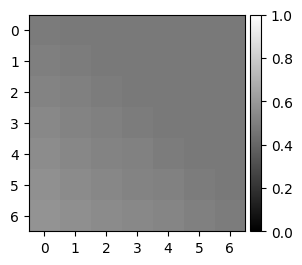

In [7]:
constraint_fn_input_dim = 2
hidden_dim = 64
constraint_nn = torch.nn.Sequential(
    torch.nn.Linear(constraint_fn_input_dim, hidden_dim), torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim, 1), torch.nn.Sigmoid(),
).to(device)
def current_constraint_function(sa):
    global constraint_nn, device
    s, a = sa
    return constraint_nn(torch.tensor(s, device=device, dtype=torch.float)) # Change this depending on the constraint_nn input
visualize_constraint(current_constraint_function)

# Generate expert trajectories

Simplified code for PPO Penalty (discrete action space):

In [8]:
obs_n = env.observation_space.shape[0]
act_n = env.action_space.n
def make_nn():
    global obs_n, act_n, device
    value_nn = torch.nn.Sequential(
        torch.nn.Linear(obs_n, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1),
    ).to(device)
    policy_nn = torch.nn.Sequential(
        torch.nn.Linear(obs_n, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, act_n),
    ).to(device)
    return value_nn, policy_nn

In [9]:
def play_episode(env, policy_nn, constraint_fn):
    global device
    S, A, R, C = [], [], [], []
    S += [env.reset()]
    done = False
    while not done:
        probs = torch.nn.Softmax(dim=-1)(policy_nn(torch.tensor(S[-1], device=device, dtype=torch.float))).view(-1)
        action = np.random.choice(act_n, p = probs.cpu().detach().numpy())
        A += [action]
        next_state, reward, done, info = env.step(action)
        C += [constraint_fn((S[-1], action))]
        S += [next_state]
        R += [reward]
    return S, A, R, C
value_nn, policy_nn = make_nn()
test_S, test_A, test_R, test_C = play_episode(test_env, policy_nn, current_constraint_function)
print(len(test_S), len(test_A), len(test_R), len(test_C))

91 90 90 90


In [10]:
discount_factor = 1.0
def discount(x):
    global discount_factor
    n = len(x)
    g = 0
    d = []
    for i in range(n):
        g = x[n-1-i]+discount_factor*g
        d = [g]+d
    return d
discount([1, 2, 3, 4])

[10.0, 9.0, 7.0, 4.0]

In [11]:
class ReplayBuffer:
    
    def __init__(self, N):
        global obs_n, device
        self.N = N
        self.S = torch.zeros((self.N, obs_n), dtype = torch.float, device = device)
        self.A = torch.zeros((self.N), dtype = torch.long, device = device)
        self.G = torch.zeros((self.N), dtype = torch.float, device = device)
        self.log_probs = torch.zeros((self.N), dtype = torch.float, device = device)
        self.i = 0
        self.filled = 0

    def add(self, S, A, G, log_probs):
        M = S.shape[0]
        self.filled = min(self.filled+M, self.N)
        assert(M <= self.N)
        for j in range(M):
            self.S[self.i] = S[j, :]
            self.A[self.i] = A[j]
            self.G[self.i] = G[j]
            self.log_probs[self.i] = log_probs[j]
            self.i = (self.i + 1) % self.N
    
    def sample(self, n):
        global device
        minibatch = random.sample(range(self.filled), min(n, self.filled))
        S, A, G, log_probs = [], [], [], []
        for mbi in minibatch:
            s, a, g, lp = self.S[mbi], self.A[mbi], self.G[mbi], self.log_probs[mbi]
            S += [s]; A += [a]; G += [g]; log_probs += [lp]
        return torch.stack(S), torch.stack(A), torch.stack(G), torch.stack(log_probs)

In [12]:
episodes_per_epoch = 20
ppo_subepochs = 25
replay_buffer_size = 10000
learning_rate = 5e-4
learning_rate_feasibility = 2.5e-5
minibatch_size = 64
clip_param = 0.1
entropy_coef = 0.01
beta = 0.99
def ppo_penalty(n_epochs, env, policy_nn, value_nn, constraint_fn, additional_fn_condition = None, additional_fn_epoch_end = None):
    # Additional function to be run when additional function condition is met
    # Additional function takes in current policy_nn and current iteration number
    global episodes_per_epoch, replay_buffer_size, learning_rate_feasibility, beta
    global ppo_subepochs, minibatch_size, learning_rate, device
    buffer = ReplayBuffer(replay_buffer_size)
    value_opt = torch.optim.Adam(value_nn.parameters(), lr = learning_rate)
    policy_opt = torch.optim.Adam(policy_nn.parameters(), lr = learning_rate)
    pbar = tqdm.notebook.tqdm(total = n_epochs)
    for epoch in range(n_epochs):
        S_e, A_e, G_e, Gc_e, Indices = [], [], [], [], []
        G0_e, Gc0_e = [], []
        for episode in range(episodes_per_epoch):
            S, A, R, C = play_episode(env, policy_nn, constraint_fn)
            start_index = len(A_e)
            S_e += S[:-1] # ignore last state
            A_e += A
            ret = discount(R)
            G_e += ret
            G0_e += [float(ret[0])]
            ret_c = discount(C)
            Gc_e += ret_c
            Gc0_e += [float(ret_c[0])]
            end_index = len(A_e)
            Indices += [(start_index, end_index)]
        pbar.set_description("Epoch %d:\tG_avg = %.2f\tGc_avg = %.2f" % (epoch, np.mean(G0_e), np.mean(Gc0_e)))
        S_e = torch.tensor(S_e, dtype=torch.float, device=device)
        A_e = torch.tensor(A_e, dtype=torch.long, device=device)
        G_e = torch.tensor(G_e, dtype=torch.float, device=device)
        Gc_e = torch.tensor(Gc_e, dtype=torch.float, device=device)
        log_probs_e = torch.nn.LogSoftmax(dim = -1)(policy_nn(S_e)).gather(1, A_e.view(-1, 1)).view(-1)
        buffer.add(S_e, A_e, G_e, log_probs_e.detach())
        feasibility_opt = torch.optim.Adam(policy_nn.parameters(), lr = learning_rate_feasibility)
        for (start_index, end_index) in Indices:
            Gc = Gc_e[start_index:end_index]
            log_probs = torch.nn.LogSoftmax(dim = -1)(policy_nn(S_e[start_index:end_index])).\
                gather(1, A_e[start_index:end_index].view(-1, 1)).view(-1)
            feasibility_opt.zero_grad()
            feasibility_loss = (Gc[0] >= beta) * ((Gc * log_probs).sum())
            feasibility_loss.backward()
            feasibility_opt.step()
        for subepoch in range(ppo_subepochs):
            S, A, G, old_log_probs = buffer.sample(minibatch_size)
            log_probs = torch.nn.LogSoftmax(dim = -1)(policy_nn(S)).gather(1, A.view(-1, 1)).view(-1)
            value_opt.zero_grad()
            value_loss = (G - value_nn(S)).pow(2).mean()
            value_loss.backward()
            value_opt.step()
            policy_opt.zero_grad()
            advantages = G - value_nn(S)
            ratio = torch.exp(log_probs - old_log_probs)
            clipped_ratio = torch.clamp(ratio, 1 - clip_param, 1 + clip_param)
            policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()
            probs_all = torch.nn.Softmax(dim=-1)(policy_nn(S))
            log_probs_all = torch.nn.LogSoftmax(dim=-1)(policy_nn(S))
            entropy = -(probs_all * log_probs_all).sum(1).mean()
            policy_loss -= entropy_coef * entropy
            policy_loss.backward()
            policy_opt.step()
        # Run additional function at epoch end if condition is met
        # Just in case we need it for later! (and we will)
        if additional_fn_condition != None and additional_fn_epoch_end != None:
            if additional_fn_condition(epoch, policy_nn) == True:
                additional_fn_epoch_end(epoch, policy_nn)
        pbar.update(1)

Collect 100 successful trajectories using a learned policy.

In [13]:
# if only_success = True, only successful trajectories are collected
def collect_trajectories(n, env, policy_nn, constraint_fn, only_success = False):
    data = []
    for traj in tqdm.notebook.tqdm(range(n)):
        S, A, R, C = play_episode(env, policy_nn, constraint_fn)
        while (not (discount(C)[0] <= beta)) and only_success:
            S, A, R, C = play_episode(test_env, policy_nn, constraint_fn)
        data += [[S[:-1], A]]
    return data

if os.path.exists("expert-data/data-tutorial.pt"):
    expert_data = torch.load("expert-data/data-tutorial.pt")
else:
    value_nn, policy_nn = make_nn()
    ppo_penalty(200, env, policy_nn, value_nn, true_constraint_function)
    expert_data = collect_trajectories(100, test_env, policy_nn, true_constraint_function, only_success = True)
    torch.save(expert_data, "expert-data/data-tutorial.pt")
print(len(expert_data))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100


Visualize the expert trajectories:

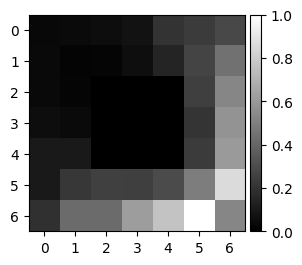

In [14]:
def visualize_accrual(data, fig = None, ax = None):
    accrual = np.array([np.zeros((gridworld_dim, gridworld_dim)) for _ in range(n_actions)])
    for (S, A) in data:
        for (s, a) in zip(S, A):
            x, y = s
            accrual[a][x][y] += 1
    accrual = np.mean(accrual, axis = 0)
    accrual /= np.max(accrual)
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    gridworld_imshow(accrual, fig, ax)

visualize_accrual(expert_data)

# Normalizing flow

Train flow on expert data:

In [15]:
def convert_to_flow_data(data):
    global device
    flow_data = []
    for (S, A) in data:
        for (s, a) in zip(S, A):
            flow_data += [s] # Change this depending on your constraint_nn input
    flow_data = torch.tensor(flow_data, dtype=torch.float, device=device)
    return flow_data
flow_data = convert_to_flow_data(expert_data)

In [16]:
flow_config = tools.data.Configuration({
    "normalize_flow_inputs": True,
    "minibatch_size": minibatch_size,
    "learning_rate": learning_rate,
})
flow_config["t"].device = device
flow = tools.functions.create_flow(flow_config, flow_data, "realnvp", constraint_fn_input_dim)
for flowepoch in range(20):
    metrics = flow.train()
    print(metrics)

{'avg_nll': 2.049517667654789, 'std_nll': 0.22197915361916512}
{'avg_nll': 1.7000525828563806, 'std_nll': 0.12020679177117323}
{'avg_nll': 1.484344724452857, 'std_nll': 0.1383861403197361}
{'avg_nll': 1.3057895609826753, 'std_nll': 0.14968801503836998}
{'avg_nll': 1.0944811828208691, 'std_nll': 0.19293375657351408}
{'avg_nll': 0.8805776491309657, 'std_nll': 0.20489773755115276}
{'avg_nll': 1.0743811401453884, 'std_nll': 0.34854285638710764}
{'avg_nll': 0.8863689923150972, 'std_nll': 0.6389349554070561}
{'avg_nll': 0.975304719173547, 'std_nll': 0.20392877633049378}
{'avg_nll': 0.7328362546183846, 'std_nll': 0.19816897066144218}
{'avg_nll': 0.5587058557253896, 'std_nll': 0.34067585120068167}
{'avg_nll': 0.4464802353106665, 'std_nll': 0.22412371651216823}
{'avg_nll': 2.0798158465009746, 'std_nll': 2.92434626244707}
{'avg_nll': 1.1357651696060642, 'std_nll': 0.18234937706965876}
{'avg_nll': 0.943294467348041, 'std_nll': 0.17308800945367536}
{'avg_nll': 0.7784192092490919, 'std_nll': 0.2008

Calculate expert data negative log likelihood using flow:

In [17]:
nll = -flow.log_probs(flow_data)
expert_nll = (nll.mean(), nll.std())

In [18]:
expert_nll

(tensor(0.0735, grad_fn=<MeanBackward0>),
 tensor(2.2252, grad_fn=<StdBackward0>))

# Cost adjustment

First let us run forward constrained RL with an initial constraint function and visualize the policy:

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

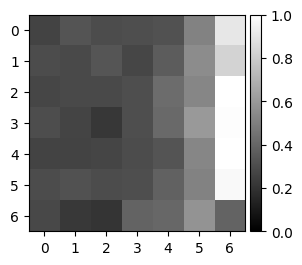

In [19]:
value_nn, policy_nn = make_nn()
ppo_penalty(200, env, policy_nn, value_nn, current_constraint_function)
agent_data = collect_trajectories(100, test_env, policy_nn, current_constraint_function)
visualize_accrual(agent_data)

In [20]:
policy_mixture = [copy.deepcopy(policy_nn.state_dict())]

In [21]:
def dissimilarity_wrt_expert(data, mean = True):
    global flow, expert_nll, device
    expert_nll_mean, expert_nll_std = expert_nll
    sims = []
    for (S, A) in data:
        traj_data = S # Change this depending on your constraint_nn input
        traj_data = torch.tensor(traj_data, dtype=torch.float, device=device)
        traj_nll = -flow.log_probs(traj_data).detach()
        sims += [(traj_nll > expert_nll_mean + expert_nll_std).float().mean()]
    if mean:
        return np.mean(sims)
    return torch.tensor(sims, dtype=torch.float, device=device)
weights_mixture = [dissimilarity_wrt_expert(agent_data)]

In [22]:
def collect_trajectories_mixture(n, env, policy_mixture, weights_mixture, constraint_fn):
    data = []
    value_nn, policy_nn = make_nn()
    normalized_weights_mixture = np.copy(weights_mixture)/np.sum(weights_mixture)
    m = len(weights_mixture)
    for traj in tqdm.notebook.tqdm(range(n)):
        chosen_policy_idx = np.random.choice(m, p = normalized_weights_mixture)
        policy_nn.load_state_dict(policy_mixture[chosen_policy_idx])
        S, A, R, C = play_episode(env, policy_nn, constraint_fn)
        data += [[S[:-1], A]]
    return data

In [23]:
def compute_current_constraint_value_trajectory(constraint_nn, data):
    global device
    Gc0 = []
    for (S, A) in data:
        input_to_constraint_nn = []
        for (s, a) in zip(S, A):
            input_to_constraint_nn += [s] # Change this depending on your constraint_nn input
        input_to_constraint_nn = torch.tensor(input_to_constraint_nn, dtype=torch.float, device=device)
        constraint_values = constraint_nn(input_to_constraint_nn).view(-1)
        Gc0 += [discount(constraint_values)[0]]
    return torch.stack(Gc0)

In [24]:
alpha = 15
def constraint_function_adjustment(n, constraint_nn, constraint_opt, expert_data, agent_data):
    global beta, alpha
    losses = []
    for _ in tqdm.notebook.tqdm(range(n)):
        constraint_opt.zero_grad()
        per_traj_dissimilarity = dissimilarity_wrt_expert(agent_data, mean = False)
        per_traj_dissimilarity = per_traj_dissimilarity / per_traj_dissimilarity.sum()
        agent_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, agent_data)
        expert_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, expert_data)
        loss1 = -(agent_data_constraint_returns * per_traj_dissimilarity).sum()
        loss2 =  ((expert_data_constraint_returns >= beta).float() * (expert_data_constraint_returns - beta)).mean()
        loss = loss1 + alpha * loss2
        loss.backward()
        constraint_opt.step()
        losses += [loss.item()]
    return np.mean(losses)

In [25]:
old_expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
constraint_opt = torch.optim.Adam(constraint_nn.parameters(), lr = learning_rate)
agent_data = collect_trajectories_mixture(100, test_env, policy_mixture, weights_mixture, current_constraint_function)
per_traj_dissimilarity = dissimilarity_wrt_expert(agent_data, mean = False)
agent_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, agent_data)
constraint_function_adjustment(20, constraint_nn, constraint_opt, expert_data, agent_data)
new_expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
old_expert_satisfaction, new_expert_satisfaction

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(tensor(0.), tensor(0.))

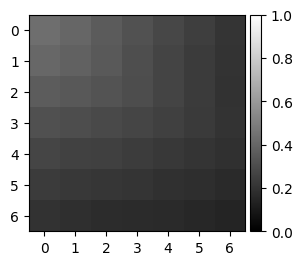

In [26]:
visualize_constraint(current_constraint_function)

# ICL

In [27]:
def icl(n_iters, flow_iters, ppo_iters, policy_add_to_mix_every, ca_iters, expert_data, seed = 1):
    seed_fn(seed)
    global constraint_nn, constraint_fn_input_dim, hidden_dim
    global env, learning_rate, policy_mixture, weights_mixture, flow, expert_nll, agent_data, device
    constraint_nn = torch.nn.Sequential(
        torch.nn.Linear(constraint_fn_input_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1), torch.nn.Sigmoid(),
    )
    constraint_opt = torch.optim.Adam(constraint_nn.parameters(), lr = learning_rate)
    print("Training flow ...")
    flow_data = convert_to_flow_data(expert_data)
    flow_config = tools.data.Configuration({
        "normalize_flow_inputs": True,
        "minibatch_size": minibatch_size,
        "learning_rate": learning_rate,
    })
    flow_config["t"].device = device
    flow = tools.functions.create_flow(flow_config, flow_data, "realnvp", constraint_fn_input_dim)
    for flowepoch in range(flow_iters):
        metrics = flow.train()
        print(metrics)
    nll = -flow.log_probs(flow_data)
    expert_nll = (nll.mean(), nll.std())
    n = len(expert_data)
    policy_mixture, weights_mixture = [], []
    print("Running ICL ...")
    expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
    print("Expert satisfaction = %.2f" % expert_satisfaction)
    def condition(epoch, policy_nn):
        if (epoch+1) % policy_add_to_mix_every == 0:
            return True
        return False
    def command(epoch, policy_nn):
        global policy_mixture, weights_mixture, agent_data
        policy_mixture += [copy.deepcopy(policy_nn.state_dict())]
        weights_mixture += [dissimilarity_wrt_expert(agent_data)]
        print("Added policy with dissimilarity = %.2f" % weights_mixture[-1])
    for itr in range(n_iters):
        print("ICL iteration %d ..." % itr)
        value_nn, policy_nn = make_nn()
        ppo_penalty(ppo_iters, env, policy_nn, value_nn, current_constraint_function, condition, command)
        agent_data = collect_trajectories(n, test_env, policy_nn, current_constraint_function)
        mixture_data = collect_trajectories_mixture(n, test_env, policy_mixture, weights_mixture, current_constraint_function)
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        visualize_constraint(true_constraint_function, fig, ax[0])
        ax[0].set_title("True constraint")
        visualize_constraint(current_constraint_function, fig, ax[1])
        ax[1].set_title("Learned constraint (itr = %d)" % itr)
        visualize_accrual(expert_data, fig, ax[2])
        ax[2].set_title("Expert accrual")
        visualize_accrual(agent_data, fig, ax[3])
        ax[3].set_title("Agent accrual")
        visualize_accrual(mixture_data, fig, ax[4])
        ax[4].set_title("Mixture accrual")
        fig.tight_layout()
        plt.show()
        per_traj_dissimilarity = dissimilarity_wrt_expert(mixture_data, mean = False)
        mixture_data_constraint_returns = compute_current_constraint_value_trajectory(constraint_nn, mixture_data)
        constraint_function_adjustment(ca_iters, constraint_nn, constraint_opt, expert_data, mixture_data)
        expert_satisfaction = (compute_current_constraint_value_trajectory(constraint_nn, expert_data) <= beta).float().mean()
        print("Expert satisfaction = %.2f" % expert_satisfaction)
    value_nn, policy_nn = make_nn()
    ppo_penalty(ppo_iters, env, policy_nn, value_nn, current_constraint_function)
    agent_data = collect_trajectories(n, test_env, policy_nn, current_constraint_function)
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    visualize_constraint(true_constraint_function, fig, ax[0])
    ax[0].set_title("True constraint")
    visualize_constraint(current_constraint_function, fig, ax[1])
    ax[1].set_title("Final constraint")
    visualize_accrual(expert_data, fig, ax[2])
    ax[2].set_title("Expert accrual")
    visualize_accrual(agent_data, fig, ax[3])
    ax[3].set_title("Final accrual")
    fig.tight_layout()
    plt.show()

Training flow ...
{'avg_nll': 2.0011243097709888, 'std_nll': 0.17740606935409808}
{'avg_nll': 1.5936767260233562, 'std_nll': 0.18421552996784893}
{'avg_nll': 1.221761905785763, 'std_nll': 0.17817862193791617}
{'avg_nll': 1.0275175228263393, 'std_nll': 0.20770776335034613}
{'avg_nll': 0.8822614767334678, 'std_nll': 0.2154420981257178}
{'avg_nll': 0.7860254717595649, 'std_nll': 0.1983058376234362}
{'avg_nll': 1.1177063620451726, 'std_nll': 0.26701758549381843}
{'avg_nll': 0.6733693634018754, 'std_nll': 0.15492942553552802}
{'avg_nll': 1.262774666150411, 'std_nll': 0.21230492650678487}
{'avg_nll': 0.8160453854185162, 'std_nll': 0.2376400235905675}
{'avg_nll': 0.8118971360452247, 'std_nll': 0.36731913478029626}
{'avg_nll': 0.7305094450712204, 'std_nll': 0.264993852240516}
{'avg_nll': 0.823254309368856, 'std_nll': 0.4315208514421639}
{'avg_nll': 0.9844037547256007, 'std_nll': 0.24813802040656635}
{'avg_nll': 0.7220241039088278, 'std_nll': 0.5241695335034692}
{'avg_nll': 0.7614139685633056, 

  0%|          | 0/200 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.33
Added policy with dissimilarity = 0.33


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

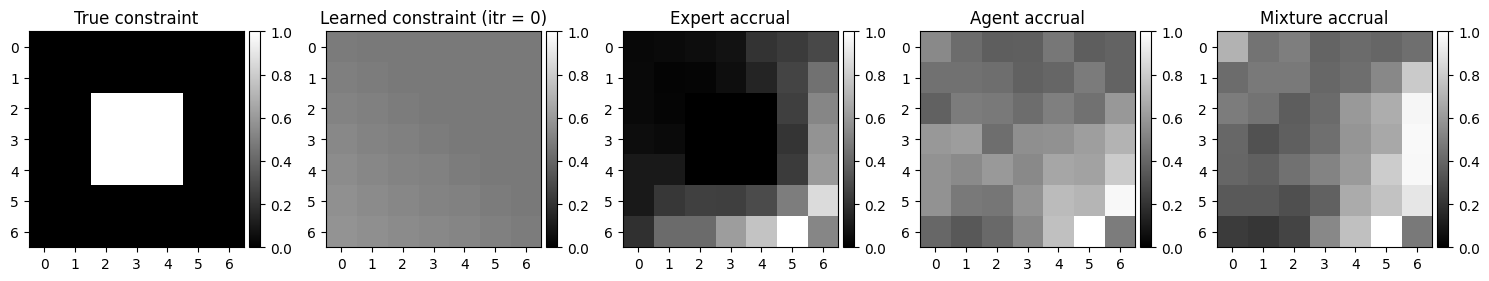

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.00
ICL iteration 1 ...


  0%|          | 0/200 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.41
Added policy with dissimilarity = 0.41


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

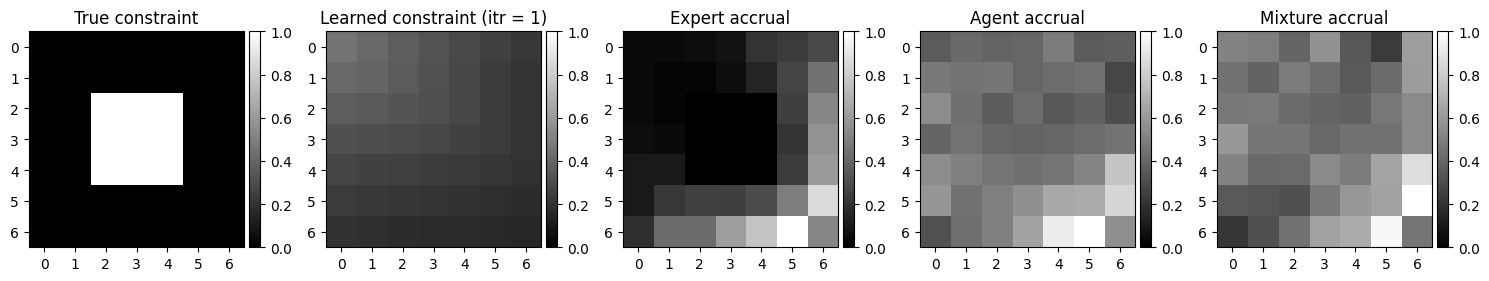

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.41
ICL iteration 2 ...


  0%|          | 0/200 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.40
Added policy with dissimilarity = 0.40


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

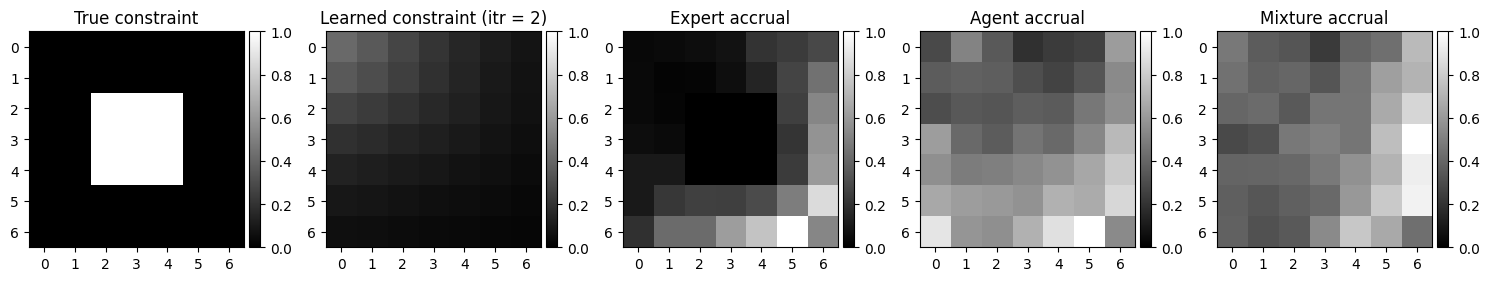

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.80
ICL iteration 3 ...


  0%|          | 0/200 [00:00<?, ?it/s]

Added policy with dissimilarity = 0.36
Added policy with dissimilarity = 0.36


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

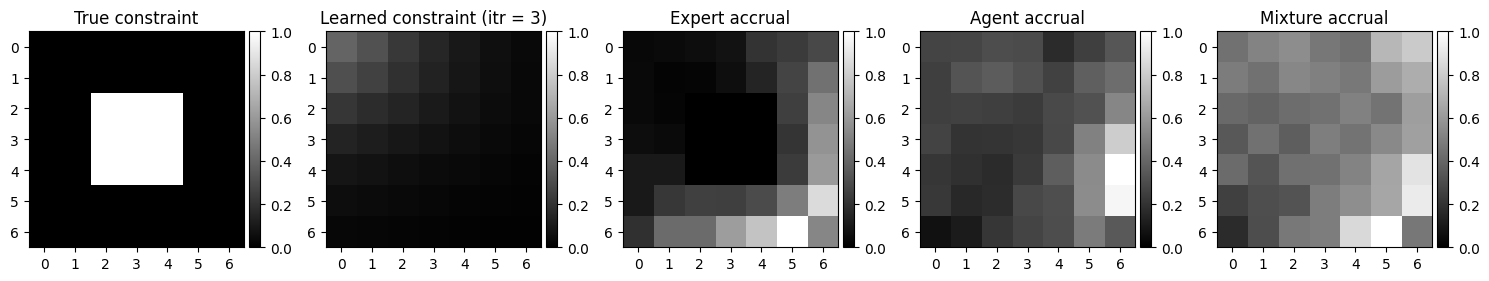

  0%|          | 0/20 [00:00<?, ?it/s]

Expert satisfaction = 0.85
ICL iteration 4 ...


  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
icl(n_iters = 10, flow_iters = 20, ppo_iters = 200, policy_add_to_mix_every = 100, ca_iters = 20, expert_data = expert_data)